Data loaded successfully.

--- Task 4: Optimizing Portfolio Based on Forecast ---


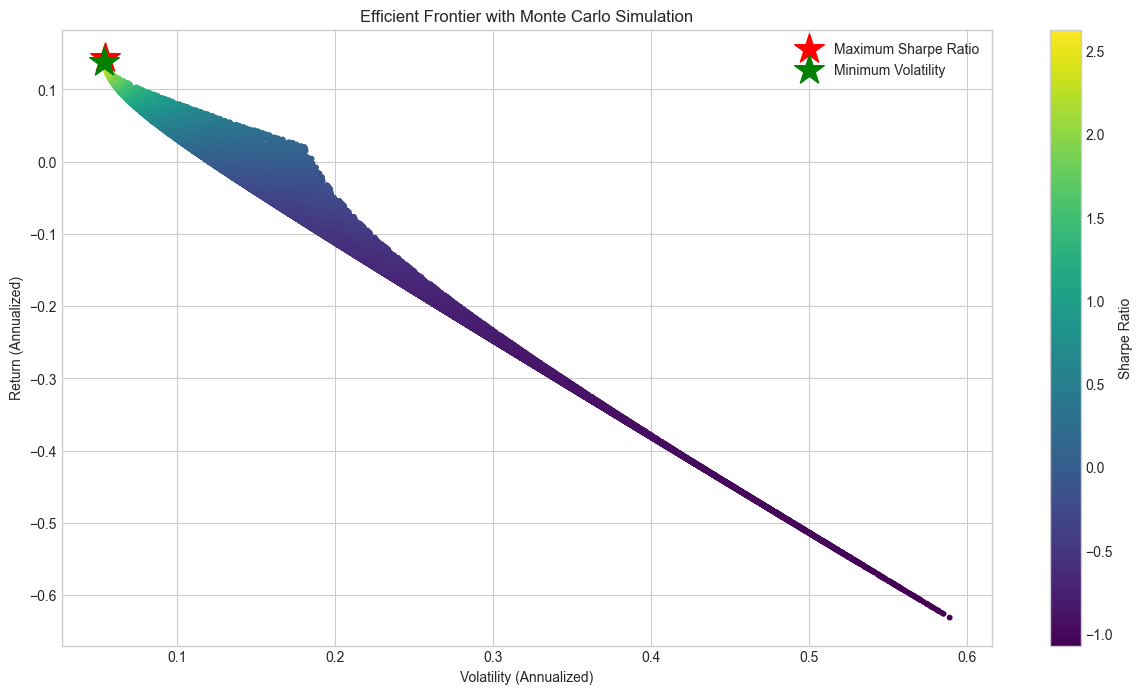


--- Optimized Portfolio Details ---

Maximum Sharpe Ratio Portfolio:
Return         0.143859
Volatility     0.054747
SharpeRatio    2.627702
Name: 6549, dtype: float64
Weights:
  TSLA: 0.04%
  BND: 99.45%
  SPY: 0.51%

Maximum Sharpe Ratio weights saved for Task 5.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')

# --- Load Data from Previous Tasks ---
try:
    returns_df = pd.read_csv('../data/processed/returns.csv', index_col=0, parse_dates=True)
    forecast_df = pd.read_csv('../data/processed/tsla_forecast.csv', index_col=0, parse_dates=True)
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: The necessary files from previous tasks were not found.")
    raise

# --- Task 4: Optimize Portfolio Based on Forecast ---
print("\n--- Task 4: Optimizing Portfolio Based on Forecast ---")

# Get historical returns for BND and SPY
historical_returns_spy_bnd = returns_df[['SPY', 'BND']]
annualized_returns_spy_bnd = historical_returns_spy_bnd.mean() * 252

# Get forecasted return for TSLA from the LSTM model
forecast_days = len(forecast_df)
tsla_forecasted_return = (forecast_df.iloc[-1, 0] / forecast_df.iloc[0, 0])**(252/forecast_days) - 1
tsla_forecasted_return = pd.Series(tsla_forecasted_return, index=['TSLA'])

# Combine returns for optimization
expected_returns = pd.concat([tsla_forecasted_return, annualized_returns_spy_bnd])

# Compute historical covariance matrix for all three assets
cov_matrix_historical = returns_df[['TSLA', 'BND', 'SPY']].cov() * 252

num_portfolios = 50000
results = np.zeros((3, num_portfolios))
weights_record = []
for i in range(num_portfolios):
    weights = np.random.random(3)
    weights /= np.sum(weights)
    weights_record.append(weights)
    portfolio_return = np.sum(weights * expected_returns)
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_historical, weights)))
    results[0, i] = portfolio_return
    results[1, i] = portfolio_std_dev
    results[2, i] = portfolio_return / portfolio_std_dev

results_frame = pd.DataFrame(results.T, columns=['Return', 'Volatility', 'SharpeRatio'])

max_sharpe_portfolio = results_frame.iloc[results_frame['SharpeRatio'].idxmax()]
min_volatility_portfolio = results_frame.iloc[results_frame['Volatility'].idxmin()]

# Plot the Efficient Frontier
plt.figure(figsize=(15, 8))
plt.scatter(results_frame['Volatility'], results_frame['Return'], c=results_frame['SharpeRatio'], cmap='viridis', s=10)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility (Annualized)')
plt.ylabel('Return (Annualized)')
plt.title('Efficient Frontier with Monte Carlo Simulation')
plt.scatter(max_sharpe_portfolio['Volatility'], max_sharpe_portfolio['Return'], marker='*', color='red', s=500, label='Maximum Sharpe Ratio')
plt.scatter(min_volatility_portfolio['Volatility'], min_volatility_portfolio['Return'], marker='*', color='green', s=500, label='Minimum Volatility')
plt.legend()
plt.show()

# Print portfolio details
print("\n--- Optimized Portfolio Details ---")
print("\nMaximum Sharpe Ratio Portfolio:")
print(max_sharpe_portfolio)
max_sharpe_weights = weights_record[results_frame['SharpeRatio'].idxmax()]
print("Weights:")
for asset, weight in zip(['TSLA', 'BND', 'SPY'], max_sharpe_weights):
    print(f"  {asset}: {weight:.2%}")

# Save the optimal weights for backtesting in Task 5
np.save('../data/processed/max_sharpe_weights.npy', max_sharpe_weights)
print("\nMaximum Sharpe Ratio weights saved for Task 5.")